<a href="https://colab.research.google.com/github/fireHedgehog/music-intrument-OvA-model/blob/main/open-mic/train_open_mic_in_res_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. mount the google drive






In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import h5py
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

# Load the HDF5 file and create X_train
def load_hdf5_file(hdf5_file_path):
    with h5py.File(hdf5_file_path, 'r') as hdf5_file:
        X_train = []
        sample_keys = []
        for sample_key in hdf5_file.keys():
            spectrogram = hdf5_file[sample_key][:]
            X_train.append(spectrogram)
            sample_keys.append(sample_key)
    return X_train, sample_keys

In [3]:
# Load the metadata file
metadata_file = '/content/drive/My Drive/datasets/openmic-2018/openmic-2018/openmic-2018-aggregated-labels.csv'
metadata = pd.read_csv(metadata_file)

In [4]:
# Load the training HDF5 file
train_hdf5_file_path = '/content/drive/My Drive/datasets/openmic-2018/train_spectrograms.h5'
X_train, sample_keys = load_hdf5_file(train_hdf5_file_path)

In [5]:
import numpy as np

# Convert X_train to a numpy array
X_train = np.array(X_train)

# Example usage
print("x_train shape:", X_train.shape)
print("x_train[0]:", X_train[0])

x_train shape: (14915, 218, 800)
x_train[0]: [[0.10258293 0.14368583 0.21555336 ... 0.60530014 0.62167129 0.63103437]
 [0.17451057 0.22862051 0.32323059 ... 0.65854224 0.67061877 0.67752564]
 [0.22467108 0.29214791 0.41012971 ... 0.86246766 0.8555632  0.85161436]
 ...
 [0.38949594 0.39086323 0.39325392 ... 0.38257781 0.37605065 0.37231759]
 [0.38949594 0.39086323 0.39325392 ... 0.38257781 0.37605065 0.37231759]
 [0.38949594 0.39086323 0.39325392 ... 0.38257781 0.37605065 0.37231759]]


In [6]:
# Expand dimensions of x_train to add the channel dimension
X_train = np.expand_dims(X_train, axis=-1)

# Example usage
# print("x_train shape:", X_train.shape)
# print("x_train[0]:", X_train[0])

In [7]:
# Extract and weight y_train
y_train_list = []
weights_list = []
for sample_key in sample_keys:
    sample_metadata = metadata[metadata["sample_key"] == sample_key]
    labels = sample_metadata[sample_metadata["relevance"] > 0.0]["instrument"].tolist()
    relevance_scores = sample_metadata[sample_metadata["relevance"] > 0.0]["relevance"].tolist()
    y_train_list.append(set(labels))
    if relevance_scores:
        weights_list.append(np.mean(relevance_scores))
    else:
        weights_list.append(1)  # Default weight if no relevance score

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train_list)

# Example usage
print("X_train shape:", X_train.shape)
print("X_train[0] shape:", X_train[0].shape if len(X_train) > 0 else "No data")
print("y_train shape:", y_train.shape)
print("Classes:", mlb.classes_)

X_train shape: (14915, 218, 800, 1)
X_train[0] shape: (218, 800, 1)
y_train shape: (14915, 20)
Classes: ['accordion' 'banjo' 'bass' 'cello' 'clarinet' 'cymbals' 'drums' 'flute'
 'guitar' 'mallet_percussion' 'mandolin' 'organ' 'piano' 'saxophone'
 'synthesizer' 'trombone' 'trumpet' 'ukulele' 'violin' 'voice']


In [8]:
# Load the testing HDF5 file
test_hdf5_file_path = '/content/drive/My Drive/datasets/openmic-2018/test_spectrograms.h5'
X_test, test_sample_keys = load_hdf5_file(test_hdf5_file_path)

# Convert X_test to a numpy array
X_test = np.array(X_test)


print("X_test shape:", X_test.shape)
print("X_test[0] shape:", X_test[0].shape if len(X_test) > 0 else "No data")

X_test shape: (5085, 218, 800)
X_test[0] shape: (218, 800)


In [9]:
# Expand dimensions of X_test to add the channel dimension
X_test = np.expand_dims(X_test, axis=-1)

# Example usage
# print("X_test shape:", X_test.shape)
# print("X_test[0]:", X_test[0])

In [10]:
# Extract and binarize y_test using the fitted mlb
y_test_list = []
for sample_key in test_sample_keys:
    sample_metadata = metadata[metadata["sample_key"] == sample_key]
    labels = sample_metadata[sample_metadata["relevance"] > 0.0]["instrument"].tolist()
    y_test_list.append(set(labels))

# reuse the training one
y_test = mlb.transform(y_test_list)
print("y_test shape:", y_test.shape)

y_test shape: (5085, 20)


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Multiply, Add, Activation,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import binary_crossentropy


In [12]:
# Modify channel_attention and coordinate_attention to return attention maps
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_layer_one = Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    attention_map = Multiply()([input_feature, cbam_feature])
    return attention_map, cbam_feature

In [13]:
def coordinate_attention(inputs, reduction_ratio=8):
    def h_swish(x):
        return x * tf.nn.relu6(x + 3) / 6

    _, h, w, c = inputs.shape

    h_avg_pool = tf.reduce_mean(inputs, axis=2, keepdims=True)
    w_avg_pool = tf.reduce_mean(inputs, axis=1, keepdims=True)

    h_avg_pool = tf.transpose(h_avg_pool, [0, 2, 1, 3])
    h_avg_pool = Conv2D(filters=c // reduction_ratio, kernel_size=1, activation=h_swish)(h_avg_pool)
    h_avg_pool = Conv2D(filters=c, kernel_size=1, activation='sigmoid')(h_avg_pool)
    h_avg_pool = tf.transpose(h_avg_pool, [0, 2, 1, 3])

    w_avg_pool = Conv2D(filters=c // reduction_ratio, kernel_size=1, activation=h_swish)(w_avg_pool)
    w_avg_pool = Conv2D(filters=c, kernel_size=1, activation='sigmoid')(w_avg_pool)

    attention_map = inputs * h_avg_pool * w_avg_pool
    return attention_map, h_avg_pool, w_avg_pool

In [14]:
from tensorflow.keras.layers import Add, Activation

def residual_block(x, filters, kernel_size=7, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # If the input and output shapes do not match, use a convolution to match them
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [13]:
"""
def custom_weighted_loss(y_true, y_pred):
    logmel_weight = 1.0
    chroma_weight = 0.5
    spectral_weight = 0.5
    tonnetz_weight = 0.5

    logmel_height = 128  # Example height for log-mel spectrogram
    chroma_height = 30   # Example height for chroma features
    spectral_height = 30  # Example height for spectral contrast features
    tonnetz_height = 30  # Example height for tonnetz features

    chroma_start = logmel_height
    spectral_start = chroma_start + chroma_height
    tonnetz_start = spectral_start + spectral_height

    epsilon = tf.keras.backend.epsilon()

    logmel_loss = binary_crossentropy(y_true[:, :logmel_height], y_pred[:, :logmel_height] + epsilon) * logmel_weight
    chroma_loss = binary_crossentropy(y_true[:, chroma_start:spectral_start], y_pred[:, chroma_start:spectral_start] + epsilon) * chroma_weight
    spectral_loss = binary_crossentropy(y_true[:, spectral_start:tonnetz_start], y_pred[:, spectral_start:tonnetz_start] + epsilon) * spectral_weight
    tonnetz_loss = binary_crossentropy(y_true[:, tonnetz_start:], y_pred[:, tonnetz_start:] + epsilon) * tonnetz_weight

    total_loss = logmel_loss + chroma_loss + spectral_loss + tonnetz_loss

    return tf.reduce_mean(total_loss)
    """

In [15]:
from re import X


def create_training_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = residual_block(inputs, 32)
    x = MaxPooling2D(pool_size=(2, 2))(x)
     # print(f"Shape after MaxPooling2D: {x.shape}")

    x, _, _ = coordinate_attention(x) # early attention

    x = residual_block(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # print(f"Shape after MaxPooling2D: {x.shape}")

    x, _, _ = coordinate_attention(x) # mid attention

    x = residual_block(x, 128)
    x = MaxPooling2D(pool_size=(2, 2))(x)
     # print(f"Shape after MaxPooling2D: {x.shape}")

    x = residual_block(x, 256)
    x = MaxPooling2D(pool_size=(2, 2))(x)
     # print(f"Shape after MaxPooling2D: {x.shape}")

    x, _ = channel_attention(x)
     # print(f"Shape after channel_attention: {x.shape}")
    x, _, _ = coordinate_attention(x)
     # print(f"Shape after coordinate_attention: {x.shape}")

    x = Flatten()(x)
     # print(f"Shape after Flatten: {x.shape}")
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
     # print(f"Shape after Dense(512): {x.shape}")
    x = Dropout(0.40)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)  # Use sigmoid for multi-label classification
     # print(f"Shape after Dense(output): {outputs.shape}")

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], weighted_metrics=[])
    return model

input_shape = (218, 800, 1)
num_classes = y_train.shape[1]

print(f"Input shape: {input_shape}")

print(f"Number of classes: {num_classes}")
training_model = create_training_model(input_shape, num_classes)

training_model.summary()


Input shape: (218, 800, 1)
Number of classes: 20
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 218, 800, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 218, 800, 32)         1600      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 218, 800, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 218, 800,

In [16]:
# better to shuffle the data
from sklearn.utils import shuffle
weights_array = np.array(weights_list)

In [17]:
# Ensure weights match the number of samples and one-hot encoding
X_train, y_train, weights_array = shuffle(X_train, y_train, weights_array, random_state=42)

In [ ]:
"""
from sklearn.model_selection import train_test_split

# Data augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val, weights_train, weights_val = train_test_split(
    X_train, y_train, weights_array, test_size=0.2, random_state=42
)
"""

In [28]:
"""
# Custom data generator to include sample weights
class WeightedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, weights, batch_size, datagen):
        self.X = X
        self.y = y
        self.weights = weights
        self.batch_size = batch_size
        self.datagen = datagen
        self.indices = np.arange(len(self.X))

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_X = self.X[batch_indices]
        batch_y = self.y[batch_indices]
        batch_weights = self.weights[batch_indices]

        augmented_batch_X = np.zeros_like(batch_X)
        for i in range(len(batch_X)):
            augmented_batch_X[i] = self.datagen.random_transform(batch_X[i])

        return augmented_batch_X, batch_y, batch_weights

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Create weighted data generators
train_generator = WeightedDataGenerator(X_train, y_train, weights_train, batch_size=32, datagen=datagen)
val_generator = WeightedDataGenerator(X_val, y_val, weights_val, batch_size=32, datagen=datagen)
"""

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


early_stopping = EarlyStopping(patience=100, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(factor=0.1, patience=50)

history = training_model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    sample_weight=weights_array,
    callbacks=[early_stopping, lr_reducer]
)

# Save the model
model_save_path = '/content/drive/My Drive/datasets/openmic-2018/model_with_attention.tf'
training_model.save(model_save_path)

# Save the training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/datasets/openmic-2018/training_history_with_attention.csv', index=False)

print("Model and training history saved successfully.")

Epoch 1/500
373/373 [==============================] - 188s 387ms/step - loss: 0.2672 - accuracy: 0.1431 - val_loss: 0.1958 - val_accuracy: 0.0627 - lr: 0.0010
Epoch 2/500
373/373 [==============================] - 94s 253ms/step - loss: 0.1621 - accuracy: 0.1983 - val_loss: 0.1685 - val_accuracy: 0.1827 - lr: 0.0010
Epoch 3/500
373/373 [==============================] - 94s 253ms/step - loss: 0.1512 - accuracy: 0.2290 - val_loss: 0.1543 - val_accuracy: 0.2243 - lr: 0.0010
Epoch 4/500
373/373 [==============================] - 94s 253ms/step - loss: 0.1446 - accuracy: 0.2622 - val_loss: 0.1443 - val_accuracy: 0.2645 - lr: 0.0010
Epoch 5/500
373/373 [==============================] - 94s 252ms/step - loss: 0.1381 - accuracy: 0.2778 - val_loss: 0.1597 - val_accuracy: 0.2105 - lr: 0.0010
Epoch 6/500
373/373 [==============================] - 94s 252ms/step - loss: 0.1329 - accuracy: 0.3019 - val_loss: 0.2077 - val_accuracy: 0.1260 - lr: 0.0010
Epoch 7/500
373/373 [========================

In [ ]:
# Load the model
# import tensorflow as tf
# model_path = '/content/drive/My Drive/datasets/openmic-2018/model_with_attention.tf'
# training_model = tf.keras.models.load_model(model_path)

In [19]:
from sklearn.metrics import accuracy_score, hamming_loss, classification_report, precision_recall_fscore_support

label_dict = {"accordion": 0, "banjo": 1, "bass": 2, "cello": 3, "clarinet": 4, "cymbals": 5, "drums": 6, "flute": 7, "guitar": 8, "mallet_percussion": 9, "mandolin": 10, "organ": 11, "piano": 12, "saxophone": 13, "synthesizer": 14, "trombone": 15, "trumpet": 16, "ukulele": 17, "violin": 18, "voice": 19}
# Step 1: Extract and sort class names based on their label values
target_names = [key for key, value in sorted(label_dict.items(), key=lambda item: item[1])]


In [21]:
# Predict the labels for the test set
y_pred = training_model.predict(X_test) # [:5]
y_pred_binary = (y_pred >= 0.5).astype(int)

small_true = y_test # [:5]

# Calculate Exact Match Ratio (EMR)
def exact_match_ratio(y_true, y_pred):
    return np.mean([np.array_equal(y_true[i], y_pred[i]) for i in range(len(y_true))])

emr = exact_match_ratio(small_true, y_pred_binary)
hl = hamming_loss(small_true, y_pred_binary)
# accuracy = accuracy_score(small_true, y_pred_binary)

# Calculate mean average precision (mAP)
precision, recall, f1, _ = precision_recall_fscore_support(small_true, y_pred_binary, average=None)
mean_average_precision = precision.mean()

print(f"Hamming Loss: {hl}")
print(classification_report(small_true, y_pred_binary, target_names=target_names))

print(f"Exact Match Ratio (EMR): {emr}")
print(f"Mean Average Precision (mAP): {mean_average_precision}")

159/159 [==============================] - 10s 64ms/step
Hamming Loss: 0.053746312684365784
                   precision    recall  f1-score   support

        accordion       1.00      0.00      0.01       233
            banjo       1.00      0.07      0.13       244
             bass       1.00      0.02      0.03       226
            cello       0.90      0.03      0.06       302
         clarinet       0.64      0.02      0.04       321
          cymbals       0.70      0.46      0.56       317
            drums       0.90      0.15      0.25       311
            flute       0.80      0.16      0.26       328
           guitar       0.57      0.35      0.44       315
mallet_percussion       0.82      0.19      0.31       280
         mandolin       0.84      0.18      0.29       329
            organ       1.00      0.04      0.08       221
            piano       0.97      0.27      0.43       304
        saxophone       0.76      0.25      0.38       389
      synthesizer     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def exact_match_ratio(y_true_list, y_pred_binary, mlb):
    # Convert one-hot encoded predictions back to multi-label format
    y_pred_labels = mlb.inverse_transform(y_pred_binary)

    # Calculate exact match ratio
    exact_matches = sum(1 for true, pred in zip(y_true_list, y_pred_labels) if set(true) == set(pred))
    return exact_matches / len(y_true_list)


emr = exact_match_ratio(y_test_list, y_pred_binary, mlb)
print(f"Exact Match Ratio (EMR): {emr}")

Exact Match Ratio (EMR): 0.27984267453294004


In [ ]:
# Save the test sample keys, true labels, and predicted labels to a DataFrame
test_labels_df = pd.DataFrame({
    'sample_key': test_sample_keys,
    'true_labels': y_test_list,
    'predicted_labels': [list(pred) for pred in y_pred]
})

# Save the DataFrame to a CSV file
test_labels_df.to_csv('/content/drive/My Drive/datasets/openmic-2018/test_sample_keys_labels_predictions.csv', index=False)

# Example usage for inspecting the data
for i in range(5):
    print(f"Sample Key: {test_sample_keys[i]}")
    print(f"True Labels: {y_test_list[i]}")
    print(f"Predicted Labels: {y_pred[i]}")

Sample Key: 000178_3840
True Labels: ['voice']
Predicted Labels: [3.5992245e-05 1.9129699e-03 2.2733393e-03 1.0072567e-03 1.6268459e-04
 4.4644973e-03 4.1702524e-02 9.0810545e-03 1.8029569e-03 3.4005910e-02
 5.0572428e-04 2.3249080e-04 2.7309083e-03 6.7996437e-04 1.1561167e-02
 7.1192882e-04 6.2487402e-04 1.2569975e-03 3.4291288e-04 3.6051860e-01]
Sample Key: 000308_61440
True Labels: ['bass']
Predicted Labels: [0.00119483 0.00138895 0.25656658 0.01708469 0.02196496 0.0056369
 0.00219774 0.034195   0.00779609 0.0100468  0.00167104 0.00278218
 0.00532581 0.03470495 0.1413422  0.00707062 0.00372197 0.00376355
 0.00207321 0.02383199]
Sample Key: 000312_184320
True Labels: []
Predicted Labels: [1.1516191e-05 8.0926652e-04 9.6009243e-03 1.5246637e-04 3.3054941e-05
 3.5928718e-03 1.7399275e-01 1.2073954e-04 1.4245290e-05 8.2164044e-03
 6.2464591e-04 3.2237465e-05 3.8100518e-03 1.8756119e-04 9.7745903e-02
 1.0346808e-02 1.5443696e-03 4.9702608e-04 8.6523251e-06 1.5049480e-03]
Sample Key: 0003

In [ ]:
import tensorflow as tf

def h_swish(x):
    return x * tf.nn.relu6(x + 3) / 6

# Load the model
model_path = '/content/drive/My Drive/datasets/openmic-2018/model_with_attention.tf'
with tf.keras.utils.custom_object_scope({'h_swish': h_swish}):
    loaded_model = tf.keras.models.load_model(model_path)

In [ ]:
for layer in loaded_model.layers:
    print(f"{layer.name}: trainable = {layer.trainable}")

input_1: trainable = True
conv2d: trainable = True
batch_normalization: trainable = True
activation: trainable = True
conv2d_1: trainable = True
conv2d_2: trainable = True
batch_normalization_1: trainable = True
batch_normalization_2: trainable = True
add: trainable = True
activation_1: trainable = True
max_pooling2d: trainable = True
tf.math.reduce_mean: trainable = True
tf.compat.v1.transpose: trainable = True
conv2d_3: trainable = True
conv2d_4: trainable = True
tf.math.reduce_mean_1: trainable = True
tf.compat.v1.transpose_1: trainable = True
conv2d_5: trainable = True
tf.math.multiply: trainable = True
conv2d_6: trainable = True
tf.math.multiply_1: trainable = True
conv2d_7: trainable = True
batch_normalization_3: trainable = True
activation_2: trainable = True
conv2d_8: trainable = True
conv2d_9: trainable = True
batch_normalization_4: trainable = True
batch_normalization_5: trainable = True
add_1: trainable = True
activation_3: trainable = True
max_pooling2d_1: trainable = True


In [ ]:
# Define the layers for early, mid, and late stages
early_layers = [
    'conv2d_8', 'conv2d_9',  # Early Conv layers
    'tf.math.multiply', 'tf.math.multiply_1'  # Early Attention layers
]

mid_layers = [
    'conv2d_18', 'conv2d_19',  # Mid Conv layers
    'tf.math.multiply_2', 'tf.math.multiply_3'  # Mid Attention layers
]

late_layers = [
    'tf.math.reduce_mean_5', 'conv2d_22',  # Late Conv layers
    'multiply', 'tf.math.multiply_5',  # Height and Width Attention
    'tf.math.multiply_4'  # Channel attention
]

# Define models to extract intermediate outputs for early, mid, and late stages
early_visualization_model = tf.keras.Model(
    inputs=loaded_model.input,
    outputs=[loaded_model.get_layer(layer).output for layer in early_layers]
)

mid_visualization_model = tf.keras.Model(
    inputs=loaded_model.input,
    outputs=[loaded_model.get_layer(layer).output for layer in mid_layers]
)

late_visualization_model = tf.keras.Model(
    inputs=loaded_model.input,
    outputs=[loaded_model.get_layer(layer).output for layer in late_layers]
)

1/1 [==============================] - 0s 178ms/step
Number of layers: 4
Expected layer names: ['Early Conv Layer 1', 'Early Conv Layer 2', 'Early Height Attention', 'Early Width Attention']
Layer 0 (Early Conv Layer 1): shape = (1, 109, 400, 64)
Layer 1 (Early Conv Layer 2): shape = (1, 109, 400, 64)
Layer 2 (Early Height Attention): shape = (1, 109, 400, 32)
Layer 3 (Early Width Attention): shape = (1, 109, 400, 32)


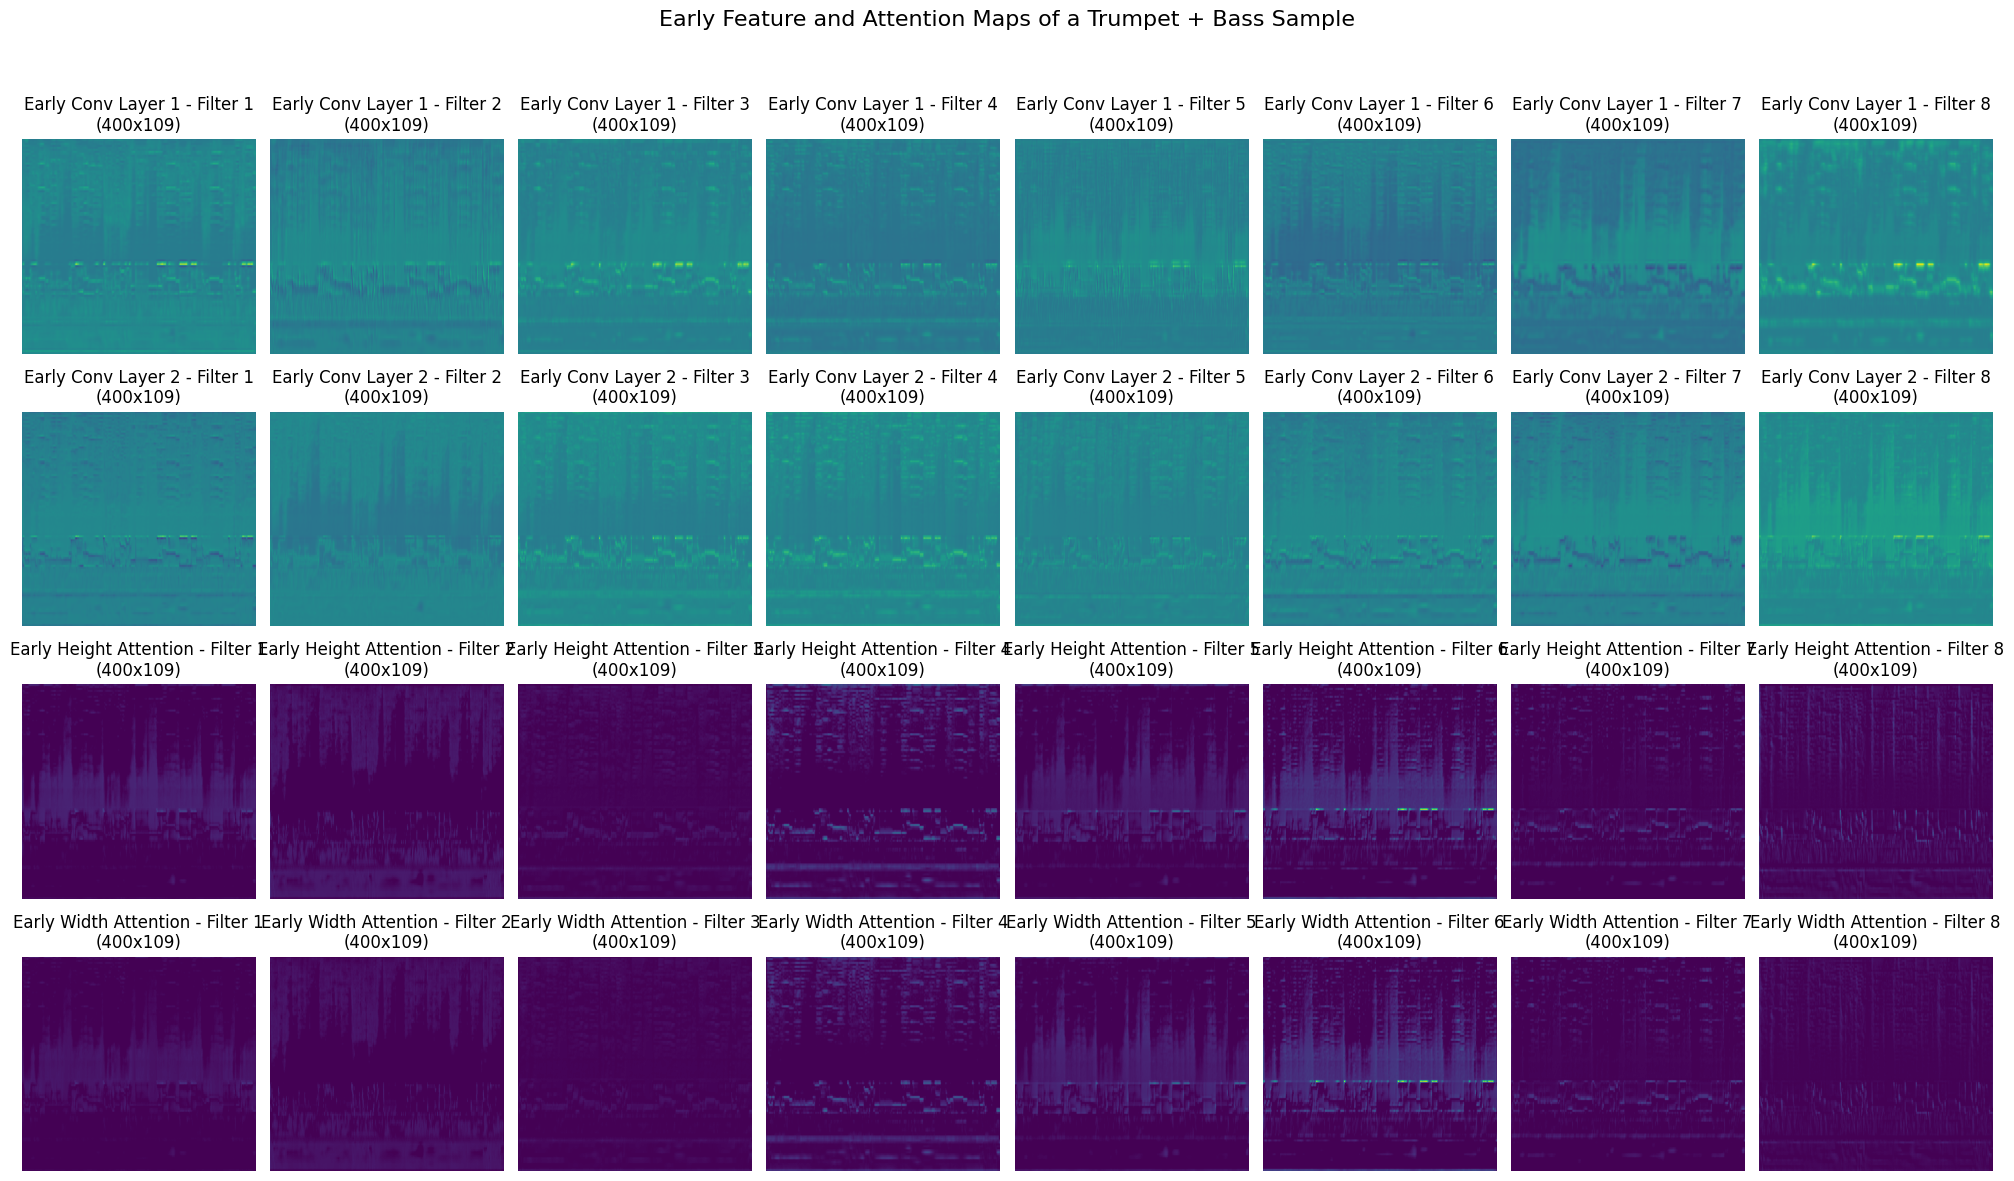

1/1 [==============================] - 0s 337ms/step
Number of layers: 4
Expected layer names: ['Mid Conv Layer 1', 'Mid Conv Layer 2', 'Mid Height Attention', 'Mid Width Attention']
Layer 0 (Mid Conv Layer 1): shape = (1, 27, 100, 256)
Layer 1 (Mid Conv Layer 2): shape = (1, 27, 100, 256)
Layer 2 (Mid Height Attention): shape = (1, 54, 200, 64)
Layer 3 (Mid Width Attention): shape = (1, 54, 200, 64)


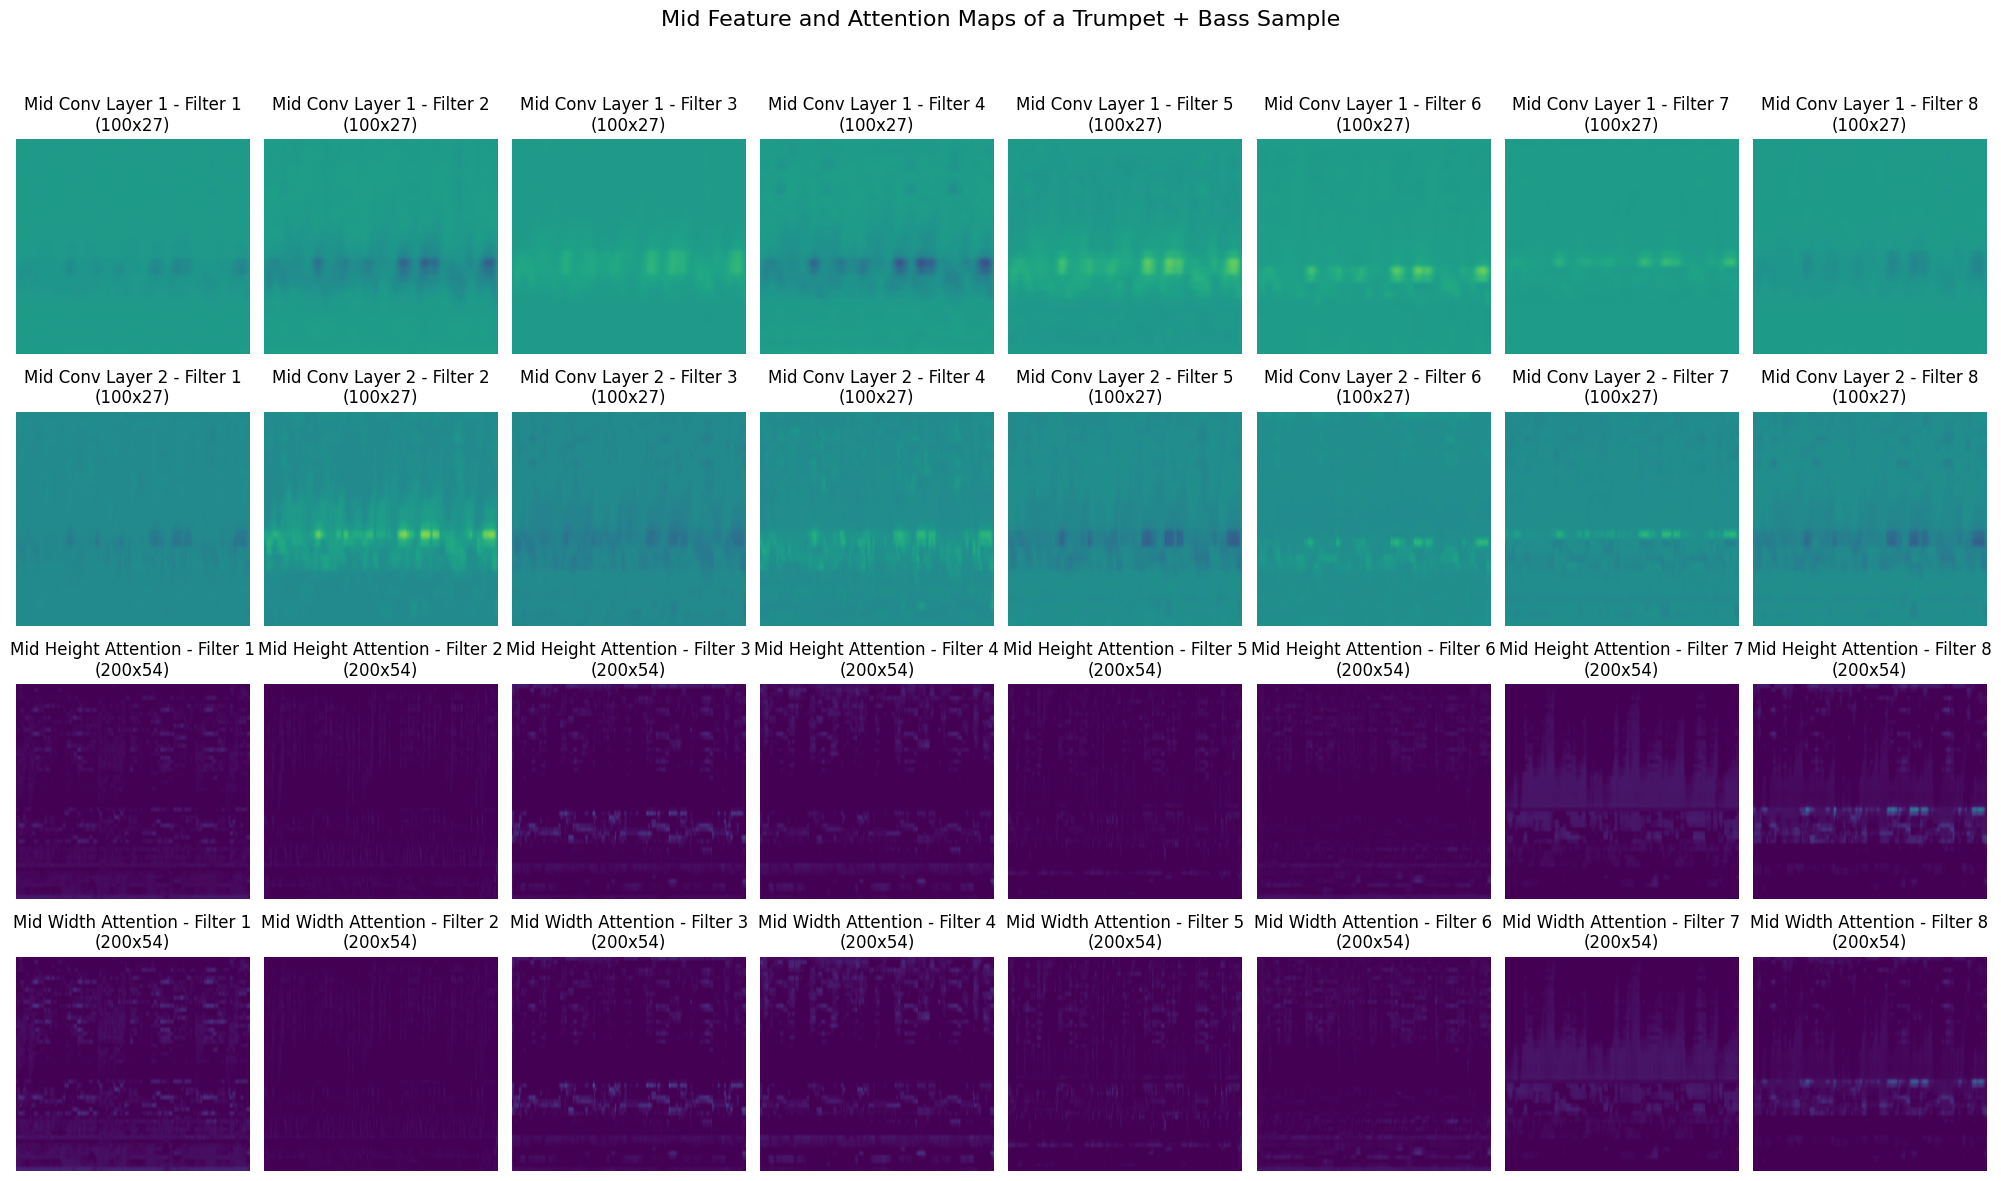

1/1 [==============================] - 0s 32ms/step
Number of layers: 5
Expected layer names: ['Late Conv Layer 1', 'Late Conv Layer 2', 'Late Height Attention', 'Late Width Attention', 'Channel Attention']
Layer 0 (Late Conv Layer 1): shape = (1, 1, 50, 256)
Layer 1 (Late Conv Layer 2): shape = (1, 1, 50, 32)
Layer 2 (Late Height Attention): shape = (1, 13, 50, 256)
Layer 3 (Late Width Attention): shape = (1, 13, 50, 256)
Layer 4 (Channel Attention): shape = (1, 13, 50, 256)


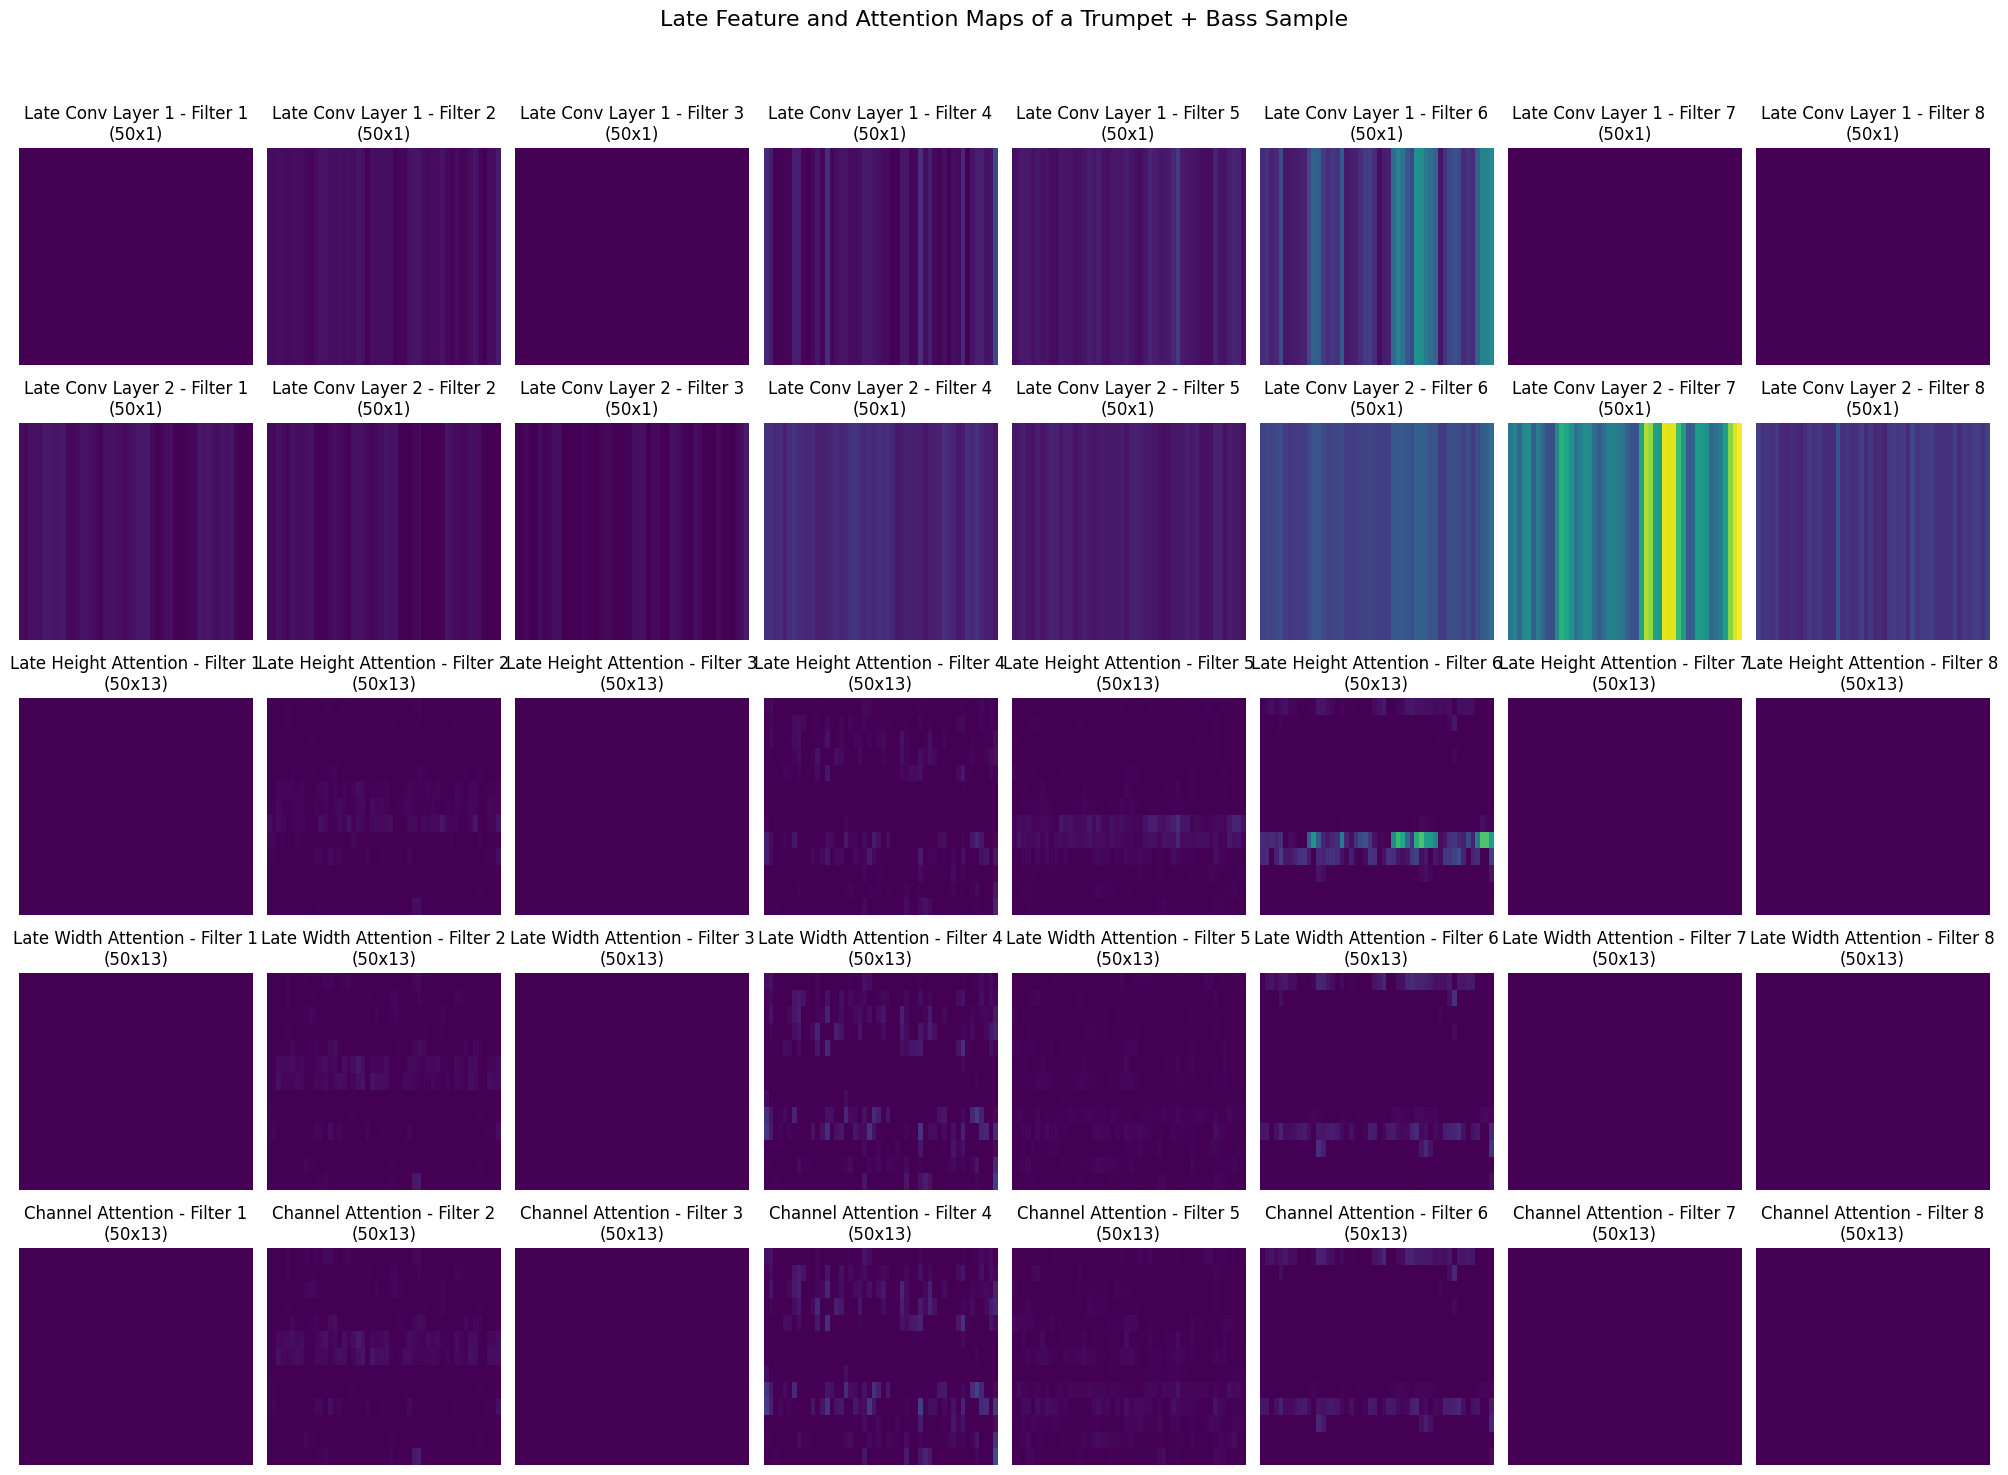

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_and_attention_maps(model, x_data, layer_names, sample_index=0, title='Feature and Attention Maps'):
    outputs = model.predict(np.expand_dims(x_data[sample_index], axis=0))

    # Debug: Print shapes of outputs
    print("Number of layers:", len(outputs))
    print("Expected layer names:", layer_names)

    for i, output in enumerate(outputs):
        print(f"Layer {i} ({layer_names[i]}): shape = {output.shape}")
        if i >= len(layer_names):
            print(f"Error: Index {i} is out of range for layer names")

    num_layers = len(outputs)
    num_filters_to_show = 8  # Number of filters to show for each layer

    plt.figure(figsize=(20, num_layers * 3))

    # Overall title
    plt.suptitle(title, fontsize=16)

    for i, output in enumerate(outputs):
        num_filters = output.shape[-1]
        height, width = output.shape[1], output.shape[2] if len(output.shape) == 4 else (output.shape[1], output.shape[2])
        vmin, vmax = output.min(), output.max()
        for j in range(min(num_filters, num_filters_to_show)):
            plt.subplot(num_layers, num_filters_to_show, i * num_filters_to_show + j + 1)
            if len(output.shape) == 4:  # Conv2D outputs
                plt.title(f'{layer_names[i]} - Filter {j+1}\n({width}x{height})')
                plt.imshow(output[0, :, :, j], aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
                plt.axis('off')
            else:  # Attention outputs (2D)
                plt.title(f'{layer_names[i]}\n({width}x{height})')
                plt.imshow(np.mean(output.squeeze(), axis=-1), aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
                plt.colorbar()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the suptitle
    plt.show()

# Use the function for early layers
plot_feature_and_attention_maps(early_visualization_model, X_test, ['Early Conv Layer 1', 'Early Conv Layer 2', 'Early Height Attention', 'Early Width Attention'], sample_index=9, title='Early Feature and Attention Maps of a Trumpet + Bass Sample')

# Use the function for mid layers
plot_feature_and_attention_maps(mid_visualization_model, X_test, ['Mid Conv Layer 1', 'Mid Conv Layer 2', 'Mid Height Attention', 'Mid Width Attention'], sample_index=9, title='Mid Feature and Attention Maps of a Trumpet + Bass Sample')

# Use the function for late layers
plot_feature_and_attention_maps(late_visualization_model, X_test, ['Late Conv Layer 1', 'Late Conv Layer 2', 'Late Height Attention', 'Late Width Attention', 'Channel Attention'], sample_index=9, title='Late Feature and Attention Maps of a Trumpet + Bass Sample')


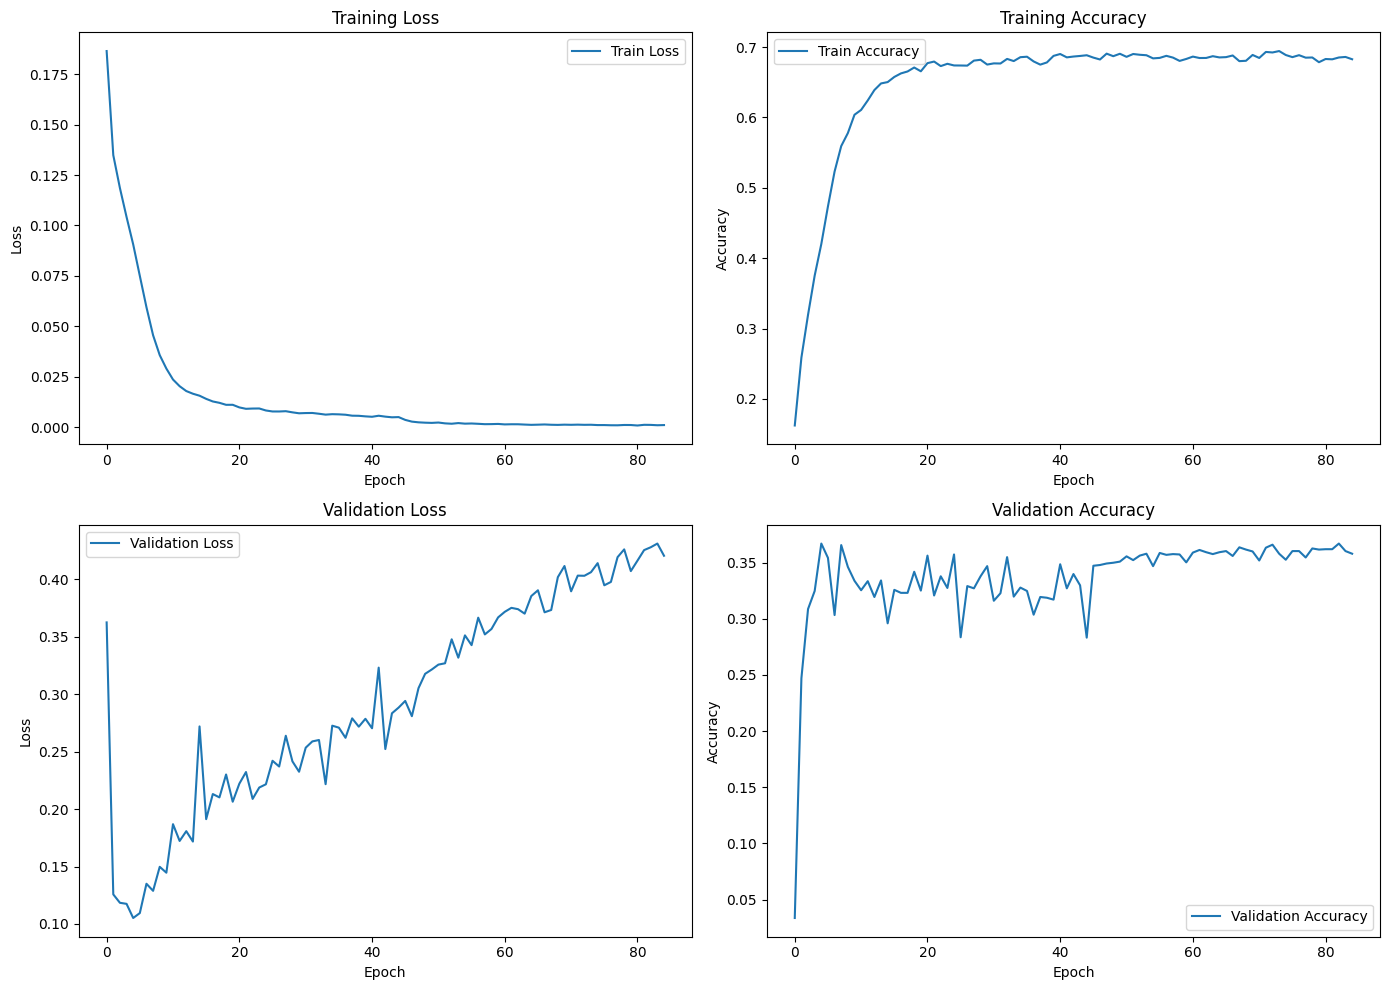

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training history
history_df = pd.read_csv('/content/drive/My Drive/datasets/openmic-2018/training_history_with_attention.csv')

# Plotting the training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plotting Training Loss
axes[0, 0].plot(history_df['loss'], label='Train Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plotting Training Accuracy
axes[0, 1].plot(history_df['accuracy'], label='Train Accuracy')
axes[0, 1].set_title('Training Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plotting Validation Loss
axes[1, 0].plot(history_df['val_loss'], label='Validation Loss')
axes[1, 0].set_title('Validation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# Plotting Validation Accuracy
axes[1, 1].plot(history_df['val_accuracy'], label='Validation Accuracy')
axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()
